<a href="https://colab.research.google.com/github/BryceTrabucco/Variational-Autoencoder-for-MNIST/blob/master/MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import torch
from torch import nn
from torchvision import transforms
from torch.autograd import Variable

import torch.distributions as torch_dist
import numpy as np
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt


In [0]:
batch_size = 32
input_dim = 784
h1_dim = 400
h2_dim = 20               # bottleneck
h3_dim = 400
output_dim = 784

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('/u/brycet/Downloads/data/processed',
                                   download = True, transform = transform)
dataloader = torch.utils.data.DataLoader(mnist, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [0]:

class VAE(torch.nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        """
        Layer Dimensions:
        
        Encoding layer 1  -> 784 input pixels, 400 output pixels
        Encoding layer 2  -> 400 input pixels, 400 output pixels
        
        Mean layer        -> 400 input pixels, 20 output pixels
        Stddev layer      -> 400 input pixels, 20 output pixels
        
        Decoder Layer 1   -> 20 input pixels,  400 output pixels
        Decoder layer 2   -> 400 input pixels, 784 output pixels
        
        """
        self.enc_layer1 = torch.nn.Linear(input_dim, h1_dim)
        self.enc_layer2 = torch.nn.Linear(h1_dim, h1_dim)
        
        self.enc_mean =   torch.nn.Linear(h1_dim, h2_dim) # mean
        self.enc_stddev = torch.nn.Linear(h1_dim, h2_dim) # standard deviation
        
        self.dec_layer1 = torch.nn.Linear(h2_dim, h3_dim)
        self.dec_layer2 = torch.nn.Linear(h3_dim, output_dim)
    
    def encode(self, x):
        h1 = F.relu(self.enc_layer1(x))
        return self.enc_layer2(h1)
    
    
    def get_latent_variables(self, x):
        
        mu = self.enc_mean(x)
        sigma = self.enc_stddev(x)
        # 
        # 
        random_samples = sigma.data.new(sigma.size()).normal_(mean = 0, std = 1)
        self.z_mean = mu
        self.z_stddev = sigma
        return mu + (sigma * random_samples)
    
    def decode(self, z):
        h2 = F.relu(self.dec_layer1(z))
        return torch.sigmoid(self.dec_layer2(h2))

    
    def forward(self, state):
        h_encoding = self.encode(state)
        z = self.get_latent_variables(h_encoding)
        return self.decode(z)



# kl_divergence = log(q) - log(p)
def latent_loss(mean, stddev):
    mean_sq = mean * mean
    variance = stddev * stddev
    return 0.5 * torch.mean(mean_sq + variance - torch.log(variance) - 1)

Epoch 0 : Combined Loss 0.2320844829082489
Epoch 0 : Combined Loss 0.22434039413928986
Epoch 0 : Combined Loss 0.21616320312023163
Epoch 0 : Combined Loss 0.19975732266902924
Epoch 0 : Combined Loss 0.17771334946155548
Epoch 0 : Combined Loss 0.13452963531017303
Epoch 0 : Combined Loss 0.10837454348802567
Epoch 0 : Combined Loss 0.09024527668952942
Epoch 0 : Combined Loss 0.08573302626609802
Epoch 0 : Combined Loss 0.0933549627661705
Epoch 0 : Combined Loss 0.08836183696985245
Epoch 0 : Combined Loss 0.08934956789016724
Epoch 0 : Combined Loss 0.08170007169246674
Epoch 0 : Combined Loss 0.08837728202342987
Epoch 0 : Combined Loss 0.085531085729599
Epoch 0 : Combined Loss 0.07746526598930359
Epoch 0 : Combined Loss 0.08176098018884659
Epoch 0 : Combined Loss 0.0754808858036995
Epoch 0 : Combined Loss 0.07712694257497787
Epoch 0 : Combined Loss 0.07523275911808014
Epoch 0 : Combined Loss 0.08085217326879501
Epoch 0 : Combined Loss 0.08153832703828812
Epoch 0 : Combined Loss 0.07858664542

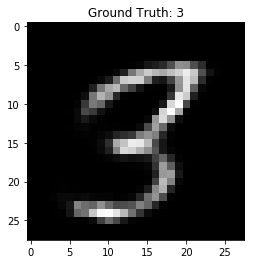

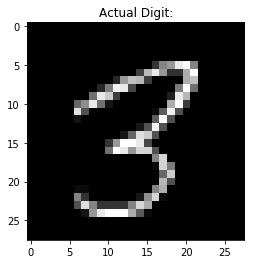

In [5]:

if __name__ == '__main__':
    
    vae = VAE()
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
    l = None
    mse_loss = torch.nn.MSELoss()
    
    for epoch in range(3):
        vae.train()
        
        
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = inputs.to(device), classes.to(device)
            
            # Reshape the input images:
            inputs, classes = inputs.resize_(batch_size, input_dim), classes
            optimizer.zero_grad()
            
            network_output = vae(inputs)
            
            ll = latent_loss(vae.z_mean, vae.z_stddev)
            
            decoder_loss = mse_loss(inputs, network_output)
            combined_loss = decoder_loss  # + ll
            combined_loss.backward()
            optimizer.step()
            
            
            print('Epoch {} : Combined Loss {}'.format(epoch, combined_loss))
            
# For the sake of computing time, I placed these lines outside of the 
# for loop.
plt.title("Ground Truth: {}".format(classes[0]))
plt.imshow(vae(inputs).cpu().data[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show(block = True)
            
plt.title("Actual Digit:")
plt.imshow(inputs.cpu().data[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show(block = True)